# MET Trigger

Measure the MET trigger efficiencies and scale factors with associated uncertaintes

## Generate histograms

In [4]:
import zdb
import glob
import os
import oyaml as yaml
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dftools

plt.style.use('cms')
plt.rcParams.update({
    "figure.dpi": 150,
    "figure.figsize": (4, 3),
    "lines.markersize": 3,
    "errorbar.capsize": 2,
})

In [5]:
def generate_yaml(hists, selection, filepath, mc=False):
    hists_def = {
        k: [
            {"table": "df: '{table_name}'"},
            {"varname0": "df: '{}'".format(k)},
            {"selection": "df: '{selection_name}'"},
            {"IsMETTriggered": "df: df.IsMETTriggered"},
            {"IsSingleMuonTriggered": "df: df.IsSingleMuonTriggered"},
            {"IsSingleElectronTriggered": "df: df.IsSingleElectronTriggered"},
            {"parent": "df: df.parent"},
            {"binvar0": "df: df.{}_bin".format(k)},
            {"count": "df: 1."},
            {"sum_w": "df: {weight}"},
            {"sum_ww": "df: df.sum_w**2"},
        ] for k in hists
    }
    
    monojet_selection = selection + ["MinDPhiJ1234METnoX>0.5"]
    monojetqcd_selection = selection + ["MinDPhiJ1234METnoX<=0.5"]
    singlemuon_selection = selection + ["MinDPhiJ1234METnoX>0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    singlemuonqcd_selection = selection + ["MinDPhiJ1234METnoX<=0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    doublemuon_selection = selection + ["MinDPhiJ1234METnoX>0.5", "nMuonSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    doublemuonqcd_selection = selection + ["MinDPhiJ1234METnoX<=0.5", "nMuonSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    singleelectron_selection = selection + ["MinDPhiJ1234METnoX>0.5", "nElectronSelection==1", "MTW>30.", "MTW<125."]
    singleelectronqcd_selection = selection + ["MinDPhiJ1234METnoX<=0.5", "nElectronSelection==1", "MTW>30.", "MTW<125."]
    doubleelectron_selection = selection + ["MinDPhiJ1234METnoX>0.5", "nElectronSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    doubleelectronqcd_selection = selection + ["MinDPhiJ1234METnoX<=0.5", "nElectronSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    singletau_selection = selection + ["MinDPhiJ1234METnoX>0.5", "nTauSelection==1"]
    singlemuonmu_selection = selection + ["MinDPhiJ1234METnoX>0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    singlemuonmuqcd_selection = selection + ["MinDPhiJ1234METnoX<=0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    doublemuonmu_selection = selection + ["MinDPhiJ1234METnoX>0.5", "nMuonSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    doublemuonmuqcd_selection = selection + ["MinDPhiJ1234METnoX<=0.5", "nMuonSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    if not mc:
        monojet_selection.extend(["nMuonVeto==0", "nElectronVeto==0", "nTauVeto==0"])
        monojetqcd_selection.extend(["nMuonVeto==0", "nElectronVeto==0", "nTauVeto==0"])
        singlemuon_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        singlemuonqcd_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        doublemuon_selection.extend(["nMuonVeto==2", "nElectronVeto==0", "nTauVeto==0"])
        doublemuonqcd_selection.extend(["nMuonVeto==2", "nElectronVeto==0", "nTauVeto==0"])
        singleelectron_selection.extend(["nMuonVeto==0", "nElectronVeto==1", "nTauVeto==0"])
        singleelectronqcd_selection.extend(["nMuonVeto==0", "nElectronVeto==1", "nTauVeto==0"])
        doubleelectron_selection.extend(["nMuonVeto==0", "nElectronVeto==2", "nTauVeto==0"])
        doubleelectronqcd_selection.extend(["nMuonVeto==0", "nElectronVeto==2", "nTauVeto==0"])
        singletau_selection.extend(["nMuonVeto==0", "nElectronVeto==0", "nTauVeto==1"])
        singlemuonmu_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        singlemuonmuqcd_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        doublemuonmu_selection.extend(["nMuonVeto==2", "nElectronVeto==0", "nTauVeto==0"])
        doublemuonmuqcd_selection.extend(["nMuonVeto==2", "nElectronVeto==0", "nTauVeto==0"])

    cutflows = {
        "Monojet": {
            "selection_name": "Monojet",
            "selection": "(" + ") & (".join(monojet_selection)+")",
            "weight": "1." if not mc else "df.Weight_Monojet",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MTW", "MLL", "JetFwd", "NearestJet", "Muon", "Electron", "Tau",
            ])],
        },
        "MonojetQCD": {
            "selection_name": "MonojetQCD",
            "selection": "(" + ") & (".join(singlemuon_selection)+")",
            "weight": "1." if not mc else "df.Weight_MonojetQCD",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MTW", "MLL", "JetFwd", "NearestJet", "Muon", "Electron", "Tau",
            ])],
        },
        "SingleMuon": {
            "selection_name": "SingleMuon",
            "selection": "(" + ") & (".join(singlemuon_selection)+")",
            "weight": "1." if not mc else "df.Weight_SingleMuon",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MLL", "JetFwd", "NearestJet", "SecondMuon", "Electron", "Tau",
            ])],
        },
        "SingleMuonQCD": {
            "selection_name": "SingleMuonQCD",
            "selection": "(" + ") & (".join(singlemuonqcd_selection)+")",
            "weight": "1." if not mc else "df.Weight_SingleMuonQCD",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MLL", "JetFwd", "NearestJet", "SecondMuon", "Electron", "Tau",
            ])],
        },
        "DoubleMuon": {
            "selection_name": "DoubleMuon",
            "selection": "(" + ") & (".join(doublemuon_selection) + ")",
            "weight": "1." if not mc else "df.Weight_DoubleMuon",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MTW", "JetFwd", "NearestJet", "Electron", "Tau",
            ])],
        },
        "DoubleMuonQCD": {
            "selection_name": "DoubleMuonQCD",
            "selection": "(" + ") & (".join(doublemuonqcd_selection) + ")",
            "weight": "1." if not mc else "df.Weight_DoubleMuonQCD",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MTW", "JetFwd", "NearestJet", "Electron", "Tau",
            ])],
        },
        "SingleElectron": {
            "selection_name": "SingleElectron",
            "selection": "(" + ") & (".join(singleelectron_selection) + ")",
            "weight": "1." if not mc else "df.Weight_SingleElectron",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MLL", "JetFwd", "NearestJet", "Muon", "SecondElectron", "Tau",
            ])],
        },
        "SingleElectronQCD": {
            "selection_name": "SingleElectronQCD",
            "selection": "(" + ") & (".join(singleelectronqcd_selection) + ")",
            "weight": "1." if not mc else "df.Weight_SingleElectronQCD",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MLL", "JetFwd", "NearestJet", "Muon", "SecondElectron", "Tau",
            ])],
        },
        "DoubleElectron": {
            "selection_name": "DoubleElectron",
            "selection": "(" + ") & (".join(doubleelectron_selection) + ")",
            "weight": "1." if not mc else "df.Weight_DoubleElectron",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MTW", "JetFwd", "NearestJet", "Muon", "Tau",
            ])],
        },
        "DoubleElectronQCD": {
            "selection_name": "DoubleElectronQCD",
            "selection": "(" + ") & (".join(doubleelectronqcd_selection) + ")",
            "weight": "1." if not mc else "df.Weight_DoubleElectronQCD",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MTW", "JetFwd", "NearestJet", "Muon", "Tau",
            ])],
        },
        "SingleTau": {
            "selection_name": "SingleTau",
            "selection": "(" + ") & (".join(singletau_selection) + ")",
            "weight": "1." if not mc else "df.Weight_SingleTau",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MLL", "MTW", "JetFwd", "NearestJet", "Muon", "Electron",
            ])],
        },
        "SingleMuonMu": {
            "selection_name": "SingleMuonMu",
            "selection": "(" + ") & (".join(singlemuonmu_selection)+")",
            "weight": "1." if not mc else "df.Weight_SingleMuonMu",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MLL", "JetFwd", "NearestJet", "SecondMuon", "Electron", "Tau",
            ])],
        },
        "SingleMuonMuQCD": {
            "selection_name": "SingleMuonMuQCD",
            "selection": "(" + ") & (".join(singlemuonmuqcd_selection)+")",
            "weight": "1." if not mc else "df.Weight_SingleMuonMuQCD",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MLL", "JetFwd", "NearestJet", "SecondMuon", "Electron", "Tau",
            ])],
        },
        "DoubleMuonMu": {
            "selection_name": "DoubleMuonMu",
            "selection": "(" + ") & (".join(doublemuonmu_selection) + ")",
            "weight": "1." if not mc else "df.Weight_DoubleMuonMu",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MTW", "JetFwd", "NearestJet", "Electron", "Tau",
            ])],
        },
        "DoubleMuonMuQCD": {
            "selection_name": "DoubleMuonMuQCD",
            "selection": "(" + ") & (".join(doublemuonmuqcd_selection) + ")",
            "weight": "1." if not mc else "df.Weight_DoubleMuonMuQCD",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MTW", "JetFwd", "NearestJet", "Electron", "Tau",
            ])],
        },
    }

    met_triggers = [
        "df.HLT_PFMETNoMu90_PFMHTNoMu90_IDTight",
        "df.HLT_PFMETNoMu100_PFMHTNoMu100_IDTight",
        "df.HLT_PFMETNoMu110_PFMHTNoMu110_IDTight",
        "df.HLT_PFMETNoMu120_PFMHTNoMu120_IDTight",
        "(df.HLT_PFMET170_NotCleaned & (df.run<276282))",
        "(df.HLT_PFMET170_BeamHaloCleaned & (df.run<276282))",
        "df.HLT_PFMET170_HBHECleaned",
        "df.HLT_PFMET170_HBHE_BeamHaloCleaned",
        "df.HLT_MET75_IsoTrk50",
    ]
    if mc:
        met_triggers = [
            "df.HLT_PFMETNoMu90_PFMHTNoMu90_IDTight",
            "df.HLT_PFMETNoMu100_PFMHTNoMu100_IDTight",
            "df.HLT_PFMETNoMu110_PFMHTNoMu110_IDTight",
            "df.HLT_PFMETNoMu120_PFMHTNoMu120_IDTight",
            "df.HLT_PFMET170_NotCleaned",
            "df.HLT_PFMET170_BeamHaloCleaned",
            "df.HLT_PFMET170_HBHECleaned",
            "df.HLT_PFMET170_HBHE_BeamHaloCleaned",
            "df.HLT_MET75_IsoTrk50",
        ]
        
    singlemuon_triggers = ["df.HLT_IsoMu24", "df.HLT_IsoTkMu24"]
    singleelectron_triggers = ["df.HLT_Ele27_WPTight_Gsf"]

    cfg_eval_bins = [
        {"METnoX_pt_bin": "df: np.floor(df.METnoX_pt/5.)*5"},
        {"MET_pt_bin": "df: np.floor(df.MET_pt/5.)*5"},
        {"LeadJetSelection_pt_bin": "df: np.floor(df.LeadJetSelection_pt/5.)*5"},
        {"LeadMuonSelection_pt_bin": "df: np.floor(df.LeadMuonSelection_pt/5.)*5"},
        {"SecondMuonSelection_pt_bin": "df: np.floor(df.SecondMuonSelection_pt/5.)*5"},
        {"LeadElectronSelection_pt_bin": "df: np.floor(df.LeadElectronSelection_pt/5.)*5"},
        {"SecondElectronSelection_pt_bin": "df: np.floor(df.SecondElectronSelection_pt/5.)*5"},
        {"LeadTauSelection_pt_bin": "df: np.floor(df.LeadTauSelection_pt/5.)*5"},
        {"PV_npvsGood_bin": "df: np.floor(df.PV_npvsGood/1.)*1"},
    ]
    
    if mc:
        weight = [
            "df.WeightXsLumi",
            "df.WeightQcdEwk",
            "df.WeightPU",
            "df.WeightPreFiring",
            "df.WeightOneMinusPhotonVetoIdLoose",
            "df.WeightOneMinusPhotonVetoPixelSeedVeto",
            "df.WeightOneMinusJetBVetoIdMedium",
        ]
        weight_ele_veto = [
            "df.WeightOneMinusElectronVetoNoSelectionIdIsoVeto",
            "df.WeightOneMinusElectronSelectionIdIsoTight",
            "df.WeightOneMinusElectronVetoReco",
        ]
        weight_ele_sele = [
            "df.WeightElectronSelectionIdIsoTight",
            "df.WeightElectronSelectionReco",
            "df.WeightOneMinusElectronVetoNoSelectionIdIsoVeto",
            "df.WeightOneMinusElectronVetoNoSelectionReco",
        ]
        weight_mu_veto = [
            "df.WeightOneMinusMuonVetoNoSelectionIdLoose",
            "df.WeightOneMinusMuonVetoNoSelectionIsoLoose",
            "df.WeightOneMinusMuonSelectionIdTight",
            "df.WeightOneMinusMuonSelectionIsoTight",
        ]
        weight_mu_sele = [
            "df.WeightMuonSelectionIdTight",
            "df.WeightMuonSelectionIsoTight",
            "df.WeightOneMinusMuonVetoNoSelectionIdLoose",
            "df.WeightOneMinusMuonVetoNoSelectionIsoLoose",
        ]
        weight_tau_veto = ["df.WeightOneMinusTauSelectionIdTight"]
        weight_tau_sele = ["df.WeightTauSelectionIdTight"]
        weight_met_trig = [] #"df.WeightMETTrig",]
        weight_singleele_trig = ["df.WeightSingleElectronTrig"]
        weight_singlemu_trig = ["df.WeightSingleMuonTrig"]
        
        
        
        cfg_eval_bins.extend([
            {"parent": "df: np.where( df.parent.isin(['WJetsToLNu', 'DYJetsToLL']), np.where( df.parent=='WJetsToLNu', np.where( df.LeptonIsElectron, np.full_like(df.parent, 'WJetsToENu'), np.where( df.LeptonIsMuon, np.full_like(df.parent, 'WJetsToMuNu'), np.where( df.LeptonIsTau, np.full_like(df.parent, 'WJetsToTauNu'), np.full_like(df.parent, 'WJetsToLNu'),),),), np.where( df.parent=='DYJetsToLL', np.where( df.LeptonIsElectron, np.full_like(df.parent, 'DYJetsToEE'), np.where( df.LeptonIsMuon, np.full_like(df.parent, 'DYJetsToMuMu'), np.where( df.LeptonIsTau, np.where( df.nGenTauL==0, np.full_like(df.parent, 'DYJetsToTauHTauH'), np.where( df.nGenTauL==1, np.full_like(df.parent, 'DYJetsToTauHTauL'), np.where( df.nGenTauL==2, np.full_like(df.parent, 'DYJetsToTauLTauL'), np.full_like(df.parent, 'DYJetsToTauTau'),),),), np.full_like(df.parent, 'DYJetsToLL'),),),), df.parent,),), df.parent,)"},
            {"Weight_Monojet": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_veto+weight_tau_veto+weight_met_trig)+")"},
            {"Weight_MonojetQCD": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_veto+weight_tau_veto+weight_met_trig)+")"},
            {"Weight_SingleMuon": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_met_trig)+")"},
            {"Weight_SingleMuonQCD": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_met_trig)+")"},
            {"Weight_DoubleMuon": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_met_trig)+")"},
            {"Weight_DoubleMuonQCD": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_met_trig)+")"},
            {"Weight_SingleElectron": "df: (" + ")*(".join(weight+weight_ele_sele+weight_mu_veto+weight_tau_veto+weight_singleele_trig)+")"},
            {"Weight_SingleElectronQCD": "df: (" + ")*(".join(weight+weight_ele_sele+weight_mu_veto+weight_tau_veto+weight_singleele_trig)+")"},
            {"Weight_DoubleElectron": "df: (" + ")*(".join(weight+weight_ele_sele+weight_mu_veto+weight_tau_veto+weight_singleele_trig)+")"},
            {"Weight_DoubleElectronQCD": "df: (" + ")*(".join(weight+weight_ele_sele+weight_mu_veto+weight_tau_veto+weight_singleele_trig)+")"},
            {"Weight_SingleTau": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_veto+weight_tau_sele+weight_met_trig)+")"},
            {"Weight_SingleMuonMu": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_singlemu_trig)+")"},
            {"Weight_SingleMuonMuQCD": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_singlemu_trig)+")"},
            {"Weight_DoubleMuonMu": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_singlemu_trig)+")"},
            {"Weight_DoubleMuonMuQCD": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_singlemu_trig)+")"},
        ])

    cfg = {
        "query": {
            "groupby": ["table", "varname0", "selection", "IsMETTriggered", "IsSingleMuonTriggered", "IsSingleElectronTriggered", "parent", "binvar0"],
            "tables": {"central": "Events"},
            "aliases": {},
            "eval": [
                {"IsMETTriggered": "df: (" + ") | (".join(met_triggers) + ")"},
                {"IsSingleMuonTriggered": "df: (" + ") | (".join(singlemuon_triggers) + ")"},
                {"IsSingleElectronTriggered": "df: (" + ") | (".join(singleelectron_triggers) + ")"},
            ] + cfg_eval_bins,
            "cutflows": cutflows,
            "hists": hists_def,
        },
        "files": sorted(p for p in glob.glob(filepath)),
    }
    
    return cfg

In [6]:
hists = ["METnoX_pt", "MET_pt", "LeadJetSelection_pt", "LeadMuonSelection_pt", "SecondMuonSelection_pt", "LeadElectronSelection_pt", "SecondElectronSelection_pt", "LeadTauSelection_pt", "PV_npvsGood"]
cfg_data = generate_yaml(
    hists,
    ["IsCertified", "Flag_goodVertices", "Flag_globalSuperTightHalo2016Filter", "Flag_HBHENoiseFilter", "Flag_HBHENoiseIsoFilter", "Flag_EcalDeadCellTriggerPrimitiveFilter", "Flag_BadPFMuonFilter", "Flag_eeBadScFilter", "MET_dCaloMET<0.6", "nJetSelection>0", "nJetSelection==nJetVeto", "LeadJetSelection_chHEF>0.1", "LeadJetSelection_neHEF<0.8", "LeadJetSelection_pt>200.", "nPhotonVeto==0", "nBJetVeto==0"],
    "/vols/cms/sdb15/Analysis/ZinvWidth/databases/2019/08_Aug/28_Legacy/Data/*.h5",
    mc=False,
)

from pprint import pprint
with open("configs/data.yaml", "w") as f:
    yaml.dump(cfg_data, f, indent=4)
    
cfg_mc = generate_yaml(
    hists,
    ["(parent!='EWKV2Jets' | nGenBosonSelection==1)", "Flag_goodVertices", "Flag_globalSuperTightHalo2016Filter", "Flag_HBHENoiseFilter", "Flag_HBHENoiseIsoFilter", "Flag_EcalDeadCellTriggerPrimitiveFilter", "Flag_BadPFMuonFilter", "MET_dCaloMET<0.6", "nJetSelection>0", "nJetSelection==nJetVeto", "LeadJetSelection_chHEF>0.1", "LeadJetSelection_neHEF<0.8", "LeadJetSelection_pt>200."],
    "/vols/cms/sdb15/Analysis/ZinvWidth/databases/2019/08_Aug/28_Legacy/MC/*.h5",
    mc=True,
)
with open("configs/mc.yaml", "w") as f:
    yaml.dump(cfg_mc, f, indent=4)

In [7]:
#zdb.modules.multi_analyse(
#    ["configs/data.yaml", "configs/mc.yaml", "configs/data_noisotrack.yaml", "configs/mc_noisotrack.yaml"],
#    outputs=[
#        "met_trigger.h5:DataAggEvents", "met_trigger.h5:MCAggEvents",
#        "met_trigger_noisotrack.h5:DataAggEvents", "met_trigger_noisotrack.h5:MCAggEvents",
#    ],
#    mode='sge',
#    ncores=100,
#    batch_opts="-q hep.q -l h_rt=3:0:0 -l h_vmem=12G",
#    chunksize=500_000,
#    merge_opts={"mode": "sge", "ncores": 25, "batch_opts": "-q hep.q"},
#)

## Functions

In [24]:
def calculate_efficiency(binning, df_pass, df_total):
    df_pass_rebin = dftools.transform.rebin(df_pass, binning)
    df_total_rebin = dftools.transform.rebin(df_total, binning)
    
    df_eff = df_pass_rebin["sum_w"].divide(df_total_rebin["sum_w"]).fillna(0.)
    
    df_total_rebin["neff"] = df_total_rebin.eval("sum_w**2 / sum_ww")
    df_pass_rebin["neff"] = df_pass_rebin.eval("sum_w**2 / sum_ww")
    df_eff_unc_down, df_eff_unc_up = dftools.stats.fc_poisson_efficiency_interval(
        df_total_rebin["neff"], df_pass_rebin["neff"],
    )
    df_eff_neff = df_pass_rebin["neff"].divide(df_total_rebin["neff"])
    df_eff_unc_down = np.minimum(np.maximum(
        np.abs(df_eff_unc_down - df_eff_neff), 0.,
    ), 1.)
    df_eff_unc_up = np.minimum(np.maximum(
        np.abs(df_eff_unc_up - df_eff_neff), 0.,
    ), 1.)
    
    return df_eff, df_eff_unc_up, df_eff_unc_down

In [32]:
def calculate_efficiencies(
    dfdata, dfmc, data_processes, mc_processes, binning,
    hist="METnoX_pt",
    data_tag=[pd.IndexSlice[:], True, pd.IndexSlice[:]],
    data_probe=[True, True, pd.IndexSlice[:]],
    mc_tag=[pd.IndexSlice[:], pd.IndexSlice[:], pd.IndexSlice[:]],
    mc_probe=[True, pd.IndexSlice[:], pd.IndexSlice[:]],
):
    dfs_mc = {}
    for region, proc in mc_processes:
        total_keys = ["central", hist, region] + mc_tag + [proc]
        df_total = dfmc.loc[tuple(total_keys),:].groupby("binvar0").sum()
        
        pass_keys = ["central", hist, region] + mc_probe + [proc]
        df_pass = dfmc.loc[tuple(pass_keys),:].groupby("binvar0").sum()
        
        dfs_mc[(region, proc)] = calculate_efficiency(
            binning, df_pass, df_total,
        )
        
    dfs_data = {}
    for region, proc in data_processes:
        total_keys = ["central", hist, region] + data_tag + [proc]
        df_total = dfdata.loc[tuple(total_keys),:].groupby("binvar0").sum()
        
        pass_keys = ["central", hist, region] + data_probe + [proc]
        df_pass = dfdata.loc[tuple(pass_keys),:].groupby("binvar0").sum()
        
        dfs_data[(region, proc)] = calculate_efficiency(
            binning, df_pass, df_total,
        )
    return dfs_data, dfs_mc

In [62]:
def draw_efficiency(
    ax, df_eff, df_eff_up, df_eff_down, binning, ismc=False,
    ax_kw={}, hist_kw={}, fill_kw={}, errorbar_kw={},
):
    if ismc:
        df_eff_unc_down = np.minimum(np.maximum(df_eff - df_eff_down, 0.), 1.)
        df_eff_unc_up = np.minimum(np.maximum(df_eff + df_eff_up, 0.), 1.)
        ax.hist(
            binning,
            bins=list(binning)+[2*binning[-1]-binning[-2]],
            weights=df_eff,
            **hist_kw,
        )
        ax.fill_between(
            list(binning)+[2*binning[-1]-binning[-2]],
            list(df_eff_unc_down)+[0.],
            list(df_eff_unc_up)+[0.],
            **fill_kw,
        )
    else:
        bin_edges = np.array(list(binning)+[2*binning[-1]-binning[-2]])
        bin_cents = (bin_edges[:-1] + bin_edges[1:])/2.
        ax.errorbar(
            bin_cents,
            df_eff,
            yerr=(df_eff_down, df_eff_up),
            **errorbar_kw,
        )
    
    ax.set_xlim(ax_kw.get("xlim", (binning.min(), 2*binning[-1]-binning[-2])))
    ax.set_ylim(ax_kw.get("ylim", (None, None)))
    if ax_kw.get("cms_label", False):
        dftools.draw.cms_label(ax, "")

In [53]:
def draw_efficiencies(
    ax, dfs_data, dfs_mc, data_processes, mc_processes, binning, 
    axins=None, hist="METnoX_pt",
    data_tag=[pd.IndexSlice[:], True, pd.IndexSlice[:]],
    data_probe=[True, True, pd.IndexSlice[:]],
    mc_tag=[pd.IndexSlice[:], pd.IndexSlice[:], pd.IndexSlice[:]],
    mc_probe=[True, pd.IndexSlice[:], pd.IndexSlice[:]],
    ax_kw={"cms_label": True, "ylim": (0., 1.05)},
    hist_kw={"zorder": 1, "histtype": "step"},
    fill_kw={"zorder": 0, "alpha": 0.3, "step": "post"},
    errorbar_kw={'fmt': 'o'},
):
    for region, proc, label, color in mc_processes:
        thist_kw = copy.deepcopy(hist_kw)
        thist_kw["label"] = label
        thist_kw["color"] = color
        
        tfill_kw = copy.deepcopy(fill_kw)
        tfill_kw["color"] = color
        
        df_eff, df_eff_up, df_eff_down = dfs_mc[(region, proc)]
        draw_efficiency(
            ax, df_eff, df_eff_up, df_eff_down, binning, ismc=True,
            ax_kw=ax_kw, hist_kw=thist_kw, fill_kw=tfill_kw,
        )
        if axins is not None:
            tax_kw = copy.deepcopy(ax_kw)
            tax_kw["cms_label"] = False
            
            draw_efficiency(
                axins, df_eff, df_eff_up, df_eff_down, binning, ismc=True,
                ax_kw=tax_kw, hist_kw=thist_kw, fill_kw=tfill_kw,
            )
        
    for region, proc, label, color in data_processes:
        terrorbar_kw = copy.deepcopy(errorbar_kw)
        terrorbar_kw["label"] = label
        terrorbar_kw["color"] = color
        
        df_eff, df_eff_up, df_eff_down = dfs_data[(region, proc)]
        draw_efficiency(
            ax, df_eff, df_eff_up, df_eff_down, binning, ismc=False,
            ax_kw=ax_kw, errorbar_kw=terrorbar_kw,
        )
        if axins is not None:
            tax_kw = copy.deepcopy(ax_kw)
            tax_kw["cms_label"] = False
            
            draw_efficiency(
                axins, df_eff, df_eff_up, df_eff_down, binning, ismc=False,
                ax_kw=tax_kw, errorbar_kw=terrorbar_kw,
            )
    return ax

In [86]:
def calculate_scalefactor(
    binning, df_data_pass, df_data_total, df_mc_pass, df_mc_total,
):
    df_data_eff, df_data_eff_unc_up, df_data_eff_unc_down = calculate_efficiency(
        binning, df_data_pass, df_data_total,
    )
    
    df_mc_eff, df_mc_eff_unc_up, df_mc_eff_unc_down = calculate_efficiency(
        binning, df_mc_pass, df_mc_total,
    )
    
    df_sf = df_data_eff.divide(df_mc_eff)
    df_sf_unc_down = df_sf * np.sqrt(
        (df_data_eff_unc_down/df_data_eff)**2
        + (df_mc_eff_unc_down/df_mc_eff)**2
    )
    df_sf_unc_up = df_sf * np.sqrt(
        (df_data_eff_unc_up/df_data_eff)**2
        + (df_mc_eff_unc_up/df_mc_eff)**2
    )
    
    return df_sf, df_sf_unc_up, df_sf_unc_down

In [94]:
def calculate_scalefactors(
    dfdata, dfmc, processes, binning,
    hist="METnoX_pt",
    data_tag=[pd.IndexSlice[:], True, pd.IndexSlice[:]],
    data_probe=[True, True, pd.IndexSlice[:]],
    mc_tag=[pd.IndexSlice[:], pd.IndexSlice[:], pd.IndexSlice[:]],
    mc_probe=[True, pd.IndexSlice[:], pd.IndexSlice[:]],
):
    dfs_sf = {}
    for data_region, data_proc, mc_region, mc_proc in processes:
        data_total_keys = ["central", hist, data_region] + data_tag + [data_proc]
        df_data_total = dfdata.loc[tuple(data_total_keys),:].groupby("binvar0").sum()
        
        data_pass_keys = ["central", hist, data_region] + data_probe + [data_proc]
        df_data_pass = dfdata.loc[tuple(data_pass_keys),:].groupby("binvar0").sum()
        
        mc_total_keys = ["central", hist, mc_region] + mc_tag + [mc_proc]
        df_mc_total = dfmc.loc[tuple(mc_total_keys),:].groupby("binvar0").sum()
        
        mc_pass_keys = ["central", hist, mc_region] + mc_probe + [mc_proc]
        df_mc_pass = dfmc.loc[tuple(mc_pass_keys),:].groupby("binvar0").sum()
        
        dfs_sf[(data_region, data_proc, mc_region, mc_proc)] = calculate_scalefactor(
            binning, df_data_pass, df_data_total, df_mc_pass, df_mc_total,
        )
    return dfs_sf

In [89]:
def draw_scalefactor(
    ax, df_sf, df_sf_unc_up, df_sf_unc_down,
    binning, ax_kw={}, errorbar_kw={},
):
    bin_edges = np.array(list(binning)+[2*binning[-1]-binning[-2]])
    bin_cents = (bin_edges[:-1] + bin_edges[1:])/2.
    ax.errorbar(
        bin_cents,
        df_sf,
        yerr=(df_sf_unc_down, df_sf_unc_up),
        **errorbar_kw,
    )
    
    ax.set_xlim(ax_kw.get("xlim", (binning.min(), 2*binning[-1]-binning[-2])))
    ax.set_ylim(ax_kw.get("ylim", (None, None)))
    if ax_kw.get("cms_label", False):
        dftools.draw.cms_label(ax, "")

In [103]:
def draw_scalefactors(
    ax, dfs_sf, processes, binning, 
    axins=None, hist="METnoX_pt",
    ax_kw={"cms_label": True, "ylim": (0., 1.05)},
    errorbar_kw={'fmt': 'o'},
):
    for data_region, data_proc, mc_region, mc_proc, label, color in processes:
        terrorbar_kw = copy.deepcopy(errorbar_kw)
        terrorbar_kw["label"] = label
        terrorbar_kw["color"] = color
        
        df_sf, df_sf_unc_up, df_sf_unc_down = dfs_sf[
            (data_region, data_proc, mc_region, mc_proc)
        ]
        draw_scalefactor(
            ax, df_sf, df_sf_unc_up, df_sf_unc_down, binning,
            ax_kw=ax_kw, errorbar_kw=terrorbar_kw,
        )

        if axins is not None:
            tax_kw = copy.deepcopy(ax_kw)
            tax_kw["cms_label"] = False
            
            draw_scalefactor(
                axins, df_sf, df_sf_unc_up, df_sf_unc_down, binning,
                ax_kw=tax_kw, errorbar_kw=terrorbar_kw,
            )
    return ax

## Initial look

Run over without the IsoTrack trigger path and see how the efficiencies in MC look like

In [38]:
df_data = pd.read_hdf("met_trigger_noisotrack.h5", "DataAggEvents")
df_mc = pd.read_hdf("met_trigger_noisotrack.h5", "MCAggEvents")

MC met trigger efficiencies without isotrack path

In [40]:
binning = np.arange(0., 501., 10.)
dfs_data, dfs_mc = calculate_efficiencies(
    df_data, df_mc, [
        ("SingleMuon", "SingleMuon"),
        ("DoubleMuon", "SingleMuon"),
    ], [
        ("Monojet", "ZJetsToNuNu"),
        ("SingleMuon", "WJetsToMuNu"),
        ("DoubleMuon", "DYJetsToMuMu"),
    ], binning, hist="METnoX_pt",
)

In [48]:
dfs_data.keys()

dict_keys([('SingleMuon', 'SingleMuon'), ('DoubleMuon', 'SingleMuon')])

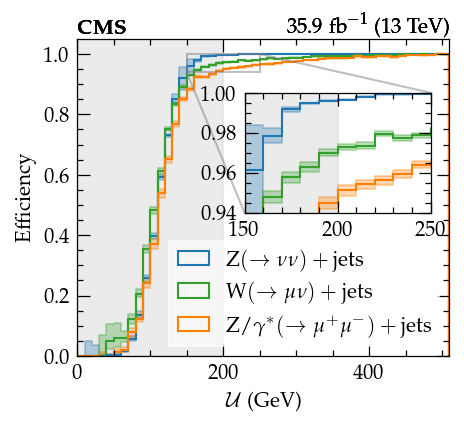

In [65]:
fig, ax = plt.subplots(
    figsize=(3.2, 2.8), dpi=150,
)
axins = ax.inset_axes([0.45, 0.45, 0.5, 0.38])

draw_efficiencies(
    ax, dfs_data, dfs_mc, [], [
        ("Monojet", "ZJetsToNuNu", r'$\mathrm{Z}(\rightarrow\nu\nu)+\mathrm{jets}$', '#1f78b4'),
        ("SingleMuon", "WJetsToMuNu", r'$\mathrm{W}(\rightarrow\mu\nu)+\mathrm{jets}$', '#33a02c'),
        ("DoubleMuon", "DYJetsToMuMu", r'$\mathrm{Z}/\gamma^{*}(\rightarrow\mu^+\mu^-)+\mathrm{jets}$', '#ff7f00'),
    ], binning, axins=axins, hist="METnoX_pt",
)

ax.legend(*ax.get_legend_handles_labels(), loc=4)

ax.set_ylim(0, 1.05)
axins.set_xlim(150, 250)
axins.set_ylim(0.94, 1.0)
ax.indicate_inset_zoom(axins)

axins.set_yticks([0.94, 0.96, 0.98, 1.00])

ax.axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)
axins.axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)

ax.set_xlabel(r'$\mathcal{U}$ (GeV)')
ax.set_ylabel(r'Efficiency')
fig.savefig("plots/met_trig_eff_mc_noisotrack.pdf", format='pdf', bbox_inches='tight')
pass

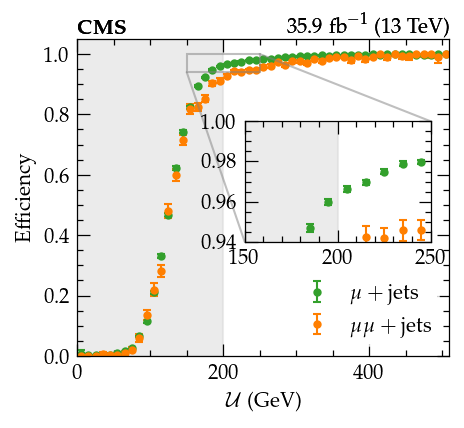

In [69]:
fig, ax = plt.subplots(
    figsize=(3.2, 2.8), dpi=150,
)
axins = ax.inset_axes([0.45, 0.36, 0.5, 0.38])

draw_efficiencies(
    ax, dfs_data, dfs_mc, [
        ("SingleMuon", "SingleMuon", r'$\mu+\mathrm{jets}$', '#33a02c'),
        ("DoubleMuon", "SingleMuon", r'$\mu\mu+\mathrm{jets}$', '#ff7f00'),
    ], [], binning, axins=axins, hist="METnoX_pt",
)

ax.legend(*ax.get_legend_handles_labels(), loc=4)

ax.set_ylim(0, 1.05)
axins.set_xlim(150, 250)
axins.set_ylim(0.94, 1.0)
ax.indicate_inset_zoom(axins)

axins.set_yticks([0.94, 0.96, 0.98, 1.00])

ax.axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)
axins.axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)

ax.set_xlabel(r'$\mathcal{U}$ (GeV)')
ax.set_ylabel(r'Efficiency')
fig.savefig("plots/met_trig_eff_data_noisotrack.pdf", format='pdf', bbox_inches='tight')
pass

## Draw

Process the aggregated data

In [70]:
df_data = pd.read_hdf("met_trigger.h5", "DataAggEvents")
df_mc = pd.read_hdf("met_trigger.h5", "MCAggEvents")

### MC MET trigger efficiency

MET trigger efficiency in MC for ZJetsToNuNu, WJetsToMuNu and DYJetsToMuMu

In [71]:
binning = np.arange(0., 501., 10.)
dfs_data, dfs_mc = calculate_efficiencies(
    df_data, df_mc, [
        ("SingleMuon", "SingleMuon"),
        ("DoubleMuon", "SingleMuon"),
    ], [
        ("Monojet", "ZJetsToNuNu"),
        ("SingleMuon", "WJetsToMuNu"),
        ("DoubleMuon", "DYJetsToMuMu"),
    ], binning, hist="METnoX_pt",
)

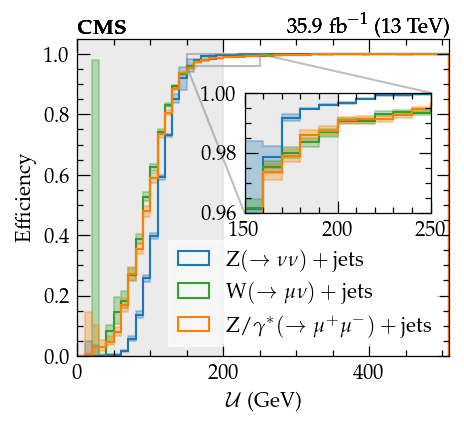

In [78]:
fig, ax = plt.subplots(
    figsize=(3.2, 2.8), dpi=150,
)
axins = ax.inset_axes([0.45, 0.45, 0.5, 0.38])

draw_efficiencies(
    ax, dfs_data, dfs_mc, [], [
        ("Monojet", "ZJetsToNuNu", r'$\mathrm{Z}(\rightarrow\nu\nu)+\mathrm{jets}$', '#1f78b4'),
        ("SingleMuon", "WJetsToMuNu", r'$\mathrm{W}(\rightarrow\mu\nu)+\mathrm{jets}$', '#33a02c'),
        ("DoubleMuon", "DYJetsToMuMu", r'$\mathrm{Z}/\gamma^{*}(\rightarrow\mu^+\mu^-)+\mathrm{jets}$', '#ff7f00'),
    ], binning, axins=axins, hist="METnoX_pt",
)

ax.legend(*ax.get_legend_handles_labels(), loc=4)

ax.set_ylim(0, 1.05)
axins.set_xlim(150, 250)
axins.set_ylim(0.96, 1.0)
ax.indicate_inset_zoom(axins)

axins.set_yticks([0.96, 0.98, 1.00])

ax.axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)
axins.axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)

ax.set_xlabel(r'$\mathcal{U}$ (GeV)')
ax.set_ylabel(r'Efficiency')
fig.savefig("plots/met_trig_eff_mc.pdf", format='pdf', bbox_inches='tight')
pass

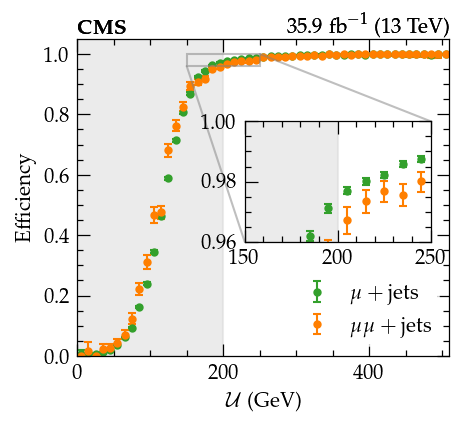

In [79]:
fig, ax = plt.subplots(
    figsize=(3.2, 2.8), dpi=150,
)
axins = ax.inset_axes([0.45, 0.36, 0.5, 0.38])

draw_efficiencies(
    ax, dfs_data, dfs_mc, [
        ("SingleMuon", "SingleMuon", r'$\mu+\mathrm{jets}$', '#33a02c'),
        ("DoubleMuon", "SingleMuon", r'$\mu\mu+\mathrm{jets}$', '#ff7f00'),
    ], [], binning, axins=axins, hist="METnoX_pt",
)

ax.legend(*ax.get_legend_handles_labels(), loc=4)

ax.set_ylim(0, 1.05)
axins.set_xlim(150, 250)
axins.set_ylim(0.96, 1.0)
ax.indicate_inset_zoom(axins)

axins.set_yticks([0.96, 0.98, 1.00])

ax.axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)
axins.axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)

ax.set_xlabel(r'$\mathcal{U}$ (GeV)')
ax.set_ylabel(r'Efficiency')
fig.savefig("plots/met_trig_eff_data.pdf", format='pdf', bbox_inches='tight')
pass

### Single Electron SF

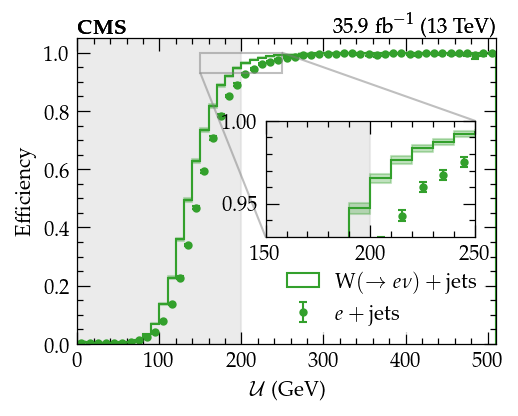

In [20]:
fig, ax = plt.subplots(
    figsize=(3.6, 2.7), dpi=150,
)
axins = ax.inset_axes([0.45, 0.35, 0.5, 0.38])

binning = np.arange(0., 501., 10.)

draw_efficiencies(
    ax, df_data, df_mc, [
        ("SingleElectron", "SingleElectron", r'$e+\mathrm{jets}$', '#33a02c'),
    ], [
        ("SingleElectron", "WJetsToENu", r'$\mathrm{W}(\rightarrow e\nu)+\mathrm{jets}$', '#33a02c'),
    ], binning, axins=axins, hist="MET_pt",
    data_tag=[pd.IndexSlice[:], pd.IndexSlice[:], True],
    data_probe=[True, pd.IndexSlice[:], True],
    mc_tag=[pd.IndexSlice[:], pd.IndexSlice[:], pd.IndexSlice[:]],
    mc_probe=[True, pd.IndexSlice[:], pd.IndexSlice[:]],
)

ax.legend(*ax.get_legend_handles_labels(), loc=4)

ax.set_ylim(0, 1.05)
axins.set_xlim(150, 250)
axins.set_ylim(0.93, 1.0)
ax.indicate_inset_zoom(axins)

ax.axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)
axins.axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)

ax.set_xlabel(r'$\mathcal{U}$ (GeV)')
ax.set_ylabel(r'Efficiency')
fig.savefig("plots/met_trig_eff_data_mc_1e.pdf", format='pdf', bbox_inches='tight')
pass

### Muon SF and systematic

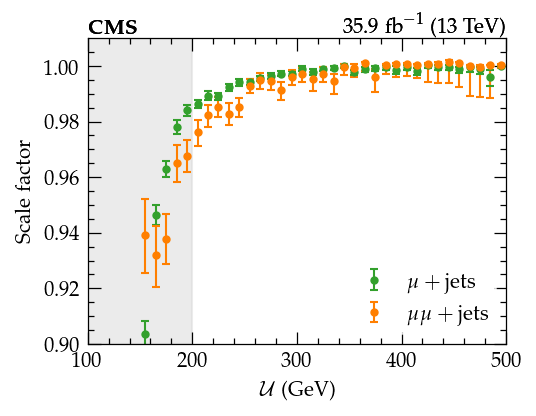

In [21]:
fig, ax = plt.subplots(
    figsize=(3.6, 2.7), dpi=150,
)
binning = np.arange(100., 500., 10.)

draw_scalefactors(
    ax, df_data, df_mc, [
        ("SingleMuon", "SingleMuon", "SingleMuon", "WJetsToMuNu", r'$\mu+\mathrm{jets}$', '#33a02c'),
        ("DoubleMuon", "SingleMuon", "DoubleMuon", "DYJetsToMuMu", r'$\mu\mu+\mathrm{jets}$', '#ff7f00'),
    ], binning, hist="METnoX_pt",
)

ax.axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)
ax.set_ylim(0.9, 1.01)

ax.set_xlabel(r'$\mathcal{U}$ (GeV)')
ax.set_ylabel(r'Scale factor')

ax.legend(*ax.get_legend_handles_labels(), loc=4)
fig.savefig("plots/met_trig_sf.pdf", format='pdf', bbox_inches='tight')
pass

In [112]:
binning = np.arange(100., 500., 10.)
dfs_sf = calculate_scalefactors(
    df_data, df_mc, [
        ("SingleMuon", "SingleMuon", "SingleMuon", "WJetsToMuNu"),
        ("SingleMuonQCD", "SingleMuon", "SingleMuonQCD", "WJetsToMuNu"),
        ("DoubleMuon", "SingleMuon", "DoubleMuon", "DYJetsToMuMu"),
    ], binning, hist="METnoX_pt",
)
dfs_sf_ref = calculate_scalefactors(
    df_data, df_mc, [
        ("SingleMuon", "SingleMuon", "SingleMuon", "WJetsToMuNu"),
    ], binning, hist="METnoX_pt",
    mc_tag=[pd.IndexSlice[:], True, pd.IndexSlice[:]],
    mc_probe=[True, True, pd.IndexSlice[:]],
)

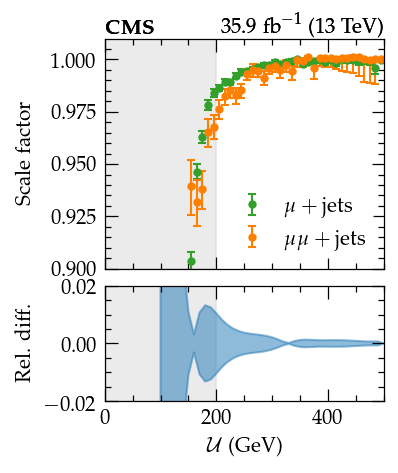

In [121]:
fig, ax = plt.subplots(
    figsize=(2.4, 3.2), dpi=150,
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2, 1), "hspace": 0.1, "wspace": 0.1},
)
binning = np.arange(100., 500., 10.)

df_sf_1mu, df_sf_1mu_up, df_sf_1mu_down = dfs_sf[("SingleMuon", "SingleMuon", "SingleMuon", "WJetsToMuNu")]
df_sf_2mu, df_sf_2mu_up, df_sf_2mu_down = dfs_sf[("DoubleMuon", "SingleMuon", "DoubleMuon", "DYJetsToMuMu")]

draw_scalefactors(
    ax[0], dfs_sf, [
        ("SingleMuon", "SingleMuon", "SingleMuon", "WJetsToMuNu", r'$\mu+\mathrm{jets}$', '#33a02c'),
        ("DoubleMuon", "SingleMuon", "DoubleMuon", "DYJetsToMuMu", r'$\mu\mu+\mathrm{jets}$', '#ff7f00'),
    ], binning, hist="METnoX_pt",
)
ax[0].set_xlim(0., 500.)
ax[0].set_ylim(0.9, 1.01)
ax[0].axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)
ax[0].set_ylabel(r'Scale factor')
ax[0].legend()

bins = list(df_sf_1mu.index.get_level_values("binvar0").unique())
bins = np.array(bins + [2*bins[-1]-bins[-2]])
bin_cents = (bins[:-1] + bins[1:])/2.
bin_edges = np.array(list(binning)+[2*binning[-1]-binning[-2]])
bin_cents = (bin_edges[:-1] + bin_edges[1:])/2.

df_sf_1mu_smooth = dftools.smooth.unispline_to_gausfilter(
    bin_cents, df_sf_1mu, spline_kw={"w": 1/df_sf_1mu_up, "k": 3},
    filter_kw={"sigma": 1},
)
df_sf_2mu_smooth = dftools.smooth.unispline_to_gausfilter(
    bin_cents, df_sf_2mu, spline_kw={"w": 1/df_sf_2mu_up, "k": 3},
    filter_kw={"sigma": 1},
)

df_sf_diff = np.abs(df_sf_1mu_smooth - df_sf_2mu_smooth)/df_sf_1mu_smooth
ax[1].fill_between(
    bins,
    list(df_sf_diff)+[0.],
    list(-df_sf_diff)+[0.],
    alpha=0.5, color='#1f78b4',
)

ax[1].set_ylim(-0.02, 0.02)
ax[1].axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)
ax[1].set_xlabel(r'$\mathcal{U}$ (GeV)')
ax[1].set_ylabel(r'Rel. diff.')

fig.align_labels(ax)
fig.savefig("plots/met_trig_sf_muonsyst.pdf", format='pdf', bbox_inches='tight')
pass

### Reference systematic

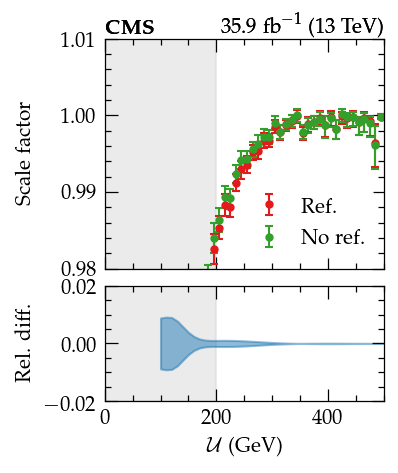

In [122]:
fig, ax = plt.subplots(
    figsize=(2.4, 3.2), dpi=150,
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2, 1), "hspace": 0.1, "wspace": 0.1},
)
binning = np.arange(100., 500., 10.)

df_sf_1mu, df_sf_1mu_up, df_sf_1mu_down = dfs_sf[("SingleMuon", "SingleMuon", "SingleMuon", "WJetsToMuNu")]
df_sf_2mu, df_sf_2mu_up, df_sf_2mu_down = dfs_sf_ref[("SingleMuon", "SingleMuon", "SingleMuon", "WJetsToMuNu")]

draw_scalefactors(
    ax[0], dfs_sf_ref, [
        ("SingleMuon", "SingleMuon", "SingleMuon", "WJetsToMuNu", r'Ref.', '#e31a1c'),
    ], binning, hist="METnoX_pt",
)
draw_scalefactors(
    ax[0], dfs_sf, [
        ("SingleMuon", "SingleMuon", "SingleMuon", "WJetsToMuNu", r'No ref.', '#33a02c'),
    ], binning, hist="METnoX_pt",
)
    
ax[0].set_xlim(0., 500.)
ax[0].set_ylim(0.98, 1.01)
ax[0].axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)
ax[0].set_ylabel(r'Scale factor')
ax[0].legend()

bins = list(df_sf_1mu.index.get_level_values("binvar0").unique())
bins = np.array(bins + [2*bins[-1]-bins[-2]])
bin_cents = (bins[:-1] + bins[1:])/2.
bin_edges = np.array(list(binning)+[2*binning[-1]-binning[-2]])
bin_cents = (bin_edges[:-1] + bin_edges[1:])/2.

df_sf_1mu_smooth = dftools.smooth.unispline_to_gausfilter(
    bin_cents, df_sf_1mu, spline_kw={"w": 1/df_sf_1mu_up, "k": 3},
    filter_kw={"sigma": 1},
)
df_sf_2mu_smooth = dftools.smooth.unispline_to_gausfilter(
    bin_cents, df_sf_2mu, spline_kw={"w": 1/df_sf_2mu_up, "k": 3},
    filter_kw={"sigma": 1},
)

df_sf_diff = np.abs(df_sf_1mu_smooth - df_sf_2mu_smooth)/df_sf_1mu_smooth
ax[1].fill_between(
    bins,
    list(df_sf_diff)+[0.],
    list(-df_sf_diff)+[0.],
    alpha=0.5, color='#1f78b4',
)

ax[1].set_ylim(-0.02, 0.02)
ax[1].axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)
ax[1].set_xlabel(r'$\mathcal{U}$ (GeV)')
ax[1].set_ylabel(r'Rel. diff.')

fig.align_labels(ax)
fig.savefig("plots/met_trig_sf_refsyst.pdf", format='pdf', bbox_inches='tight')
pass

### QCD sideband

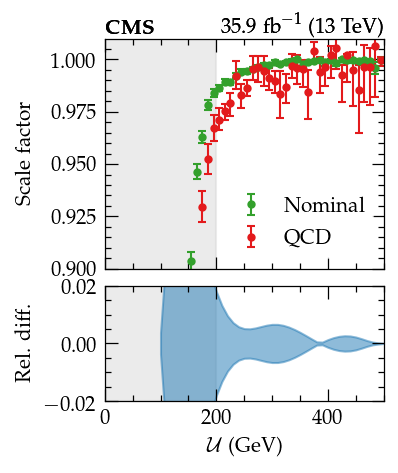

In [123]:
fig, ax = plt.subplots(
    figsize=(2.4, 3.2), dpi=150,
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2, 1), "hspace": 0.1, "wspace": 0.1},
)
binning = np.arange(100., 500., 10.)

df_sf_1mu, df_sf_1mu_up, df_sf_1mu_down = dfs_sf[("SingleMuon", "SingleMuon", "SingleMuon", "WJetsToMuNu")]
df_sf_2mu, df_sf_2mu_up, df_sf_2mu_down = dfs_sf[("SingleMuonQCD", "SingleMuon", "SingleMuonQCD", "WJetsToMuNu")]

draw_scalefactors(
    ax[0], dfs_sf, [
        ("SingleMuon", "SingleMuon", "SingleMuon", "WJetsToMuNu", r'Nominal', '#33a02c'),
        ("SingleMuonQCD", "SingleMuon", "SingleMuonQCD", "WJetsToMuNu", r'QCD', '#e31a1c'),
    ], binning, hist="METnoX_pt",
)
ax[0].set_xlim(0., 500.)
ax[0].set_ylim(0.9, 1.01)
ax[0].axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)
ax[0].set_ylabel(r'Scale factor')
ax[0].legend(loc=4)

bins = list(df_sf_1mu.index.get_level_values("binvar0").unique())
bins = np.array(bins + [2*bins[-1]-bins[-2]])
bin_cents = (bins[:-1] + bins[1:])/2.
bin_edges = np.array(list(binning)+[2*binning[-1]-binning[-2]])
bin_cents = (bin_edges[:-1] + bin_edges[1:])/2.

df_sf_1mu_smooth = dftools.smooth.unispline_to_gausfilter(
    bin_cents, df_sf_1mu, spline_kw={"w": 1/df_sf_1mu_up, "k": 3},
    filter_kw={"sigma": 1},
)
df_sf_2mu_smooth = dftools.smooth.unispline_to_gausfilter(
    bin_cents, df_sf_2mu, spline_kw={"w": 1/df_sf_2mu_up, "k": 3},
    filter_kw={"sigma": 1},
)

df_sf_diff = np.abs(df_sf_1mu_smooth - df_sf_2mu_smooth)/df_sf_1mu_smooth
ax[1].fill_between(
    bins,
    list(df_sf_diff)+[0.],
    list(-df_sf_diff)+[0.],
    alpha=0.5, color='#1f78b4',
)

ax[1].set_ylim(-0.02, 0.02)
ax[1].axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)
ax[1].set_xlabel(r'$\mathcal{U}$ (GeV)')
ax[1].set_ylabel(r'Rel. diff.')

fig.align_labels(ax)
fig.savefig("plots/met_trig_sf_qcdsyst.pdf", format='pdf', bbox_inches='tight')
pass

## Systematics

In [25]:
data_systs = {}

### Muon systematic

Systematic uncertainty associated with additional muons. Taken from the difference in scale factors between the SingleMuon and DoubleMuon regions

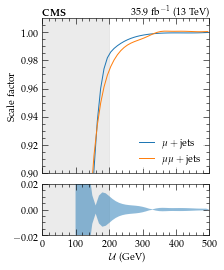

In [26]:
fig, ax = plt.subplots(
    figsize=(3, 4),
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (3, 1), "hspace": 0.1},
)
binning = np.arange(100., 500., 10.)

df_wlv_total = (
    df_mc.loc[("central", "METnoX_pt", "SingleMuon", pd.IndexSlice[:], pd.IndexSlice[:], pd.IndexSlice[:], "WJetsToMuNu"), :]
    .groupby("binvar0").sum()
)
df_wlv_pass = (
    df_mc.loc[("central", "METnoX_pt", "SingleMuon", True, pd.IndexSlice[:], pd.IndexSlice[:], "WJetsToMuNu"), :]
    .groupby("binvar0").sum()
)

df_1mu_total = (
    df_data.loc[("central", "METnoX_pt", "SingleMuon", pd.IndexSlice[:], True, pd.IndexSlice[:], "SingleMuon"), :]
    .groupby("binvar0").sum()
)
df_1mu_pass = (
    df_data.loc[("central", "METnoX_pt", "SingleMuon", True, True, pd.IndexSlice[:], "SingleMuon"), :]
    .groupby("binvar0").sum()
)

df_sf_1mu, df_sf_1mu_up, df_sf_1mu_down = calculate_scalefactor(
    binning, df_1mu_pass, df_1mu_total, df_wlv_pass, df_wlv_total,
)
data_systs["ScaleFactor"] = df_sf_1mu.values


df_zll_total = (
    df_mc.loc[("central", "METnoX_pt", "DoubleMuon", pd.IndexSlice[:], pd.IndexSlice[:], pd.IndexSlice[:], "DYJetsToMuMu"), :]
    .groupby("binvar0").sum()
)
df_zll_pass = (
    df_mc.loc[("central", "METnoX_pt", "DoubleMuon", True, pd.IndexSlice[:], pd.IndexSlice[:], "DYJetsToMuMu"), :]
    .groupby("binvar0").sum()
)

df_2mu_total = (
    df_data.loc[("central", "METnoX_pt", "DoubleMuon", pd.IndexSlice[:], True, pd.IndexSlice[:], "SingleMuon"), :]
    .groupby("binvar0").sum()
)
df_2mu_pass = (
    df_data.loc[("central", "METnoX_pt", "DoubleMuon", True, True, pd.IndexSlice[:], "SingleMuon"), :]
    .groupby("binvar0").sum()
)

df_sf_2mu, df_sf_2mu_up, df_sf_2mu_down = calculate_scalefactor(
    binning, df_2mu_pass, df_2mu_total, df_zll_pass, df_zll_total,
)

bins = list(df_sf_1mu.index.get_level_values("binvar0").unique())
bins = np.array(bins + [2*bins[-1]-bins[-2]])
bin_cents = (bins[:-1] + bins[1:])/2.

df_sf_1mu_smooth = dftools.smooth.unispline_to_gausfilter(
    bin_cents, df_sf_1mu, spline_kw={"w": 1/df_sf_1mu_up, "k": 3},
    filter_kw={"sigma": 1},
)
df_sf_2mu_smooth = dftools.smooth.unispline_to_gausfilter(
    bin_cents, df_sf_2mu, spline_kw={"w": 1/df_sf_2mu_up, "k": 3},
    filter_kw={"sigma": 1},
)

ax[0].plot(bin_cents, df_sf_1mu_smooth, label=r'$\mu+\mathrm{jets}$')
ax[0].plot(bin_cents, df_sf_2mu_smooth, label=r'$\mu\mu+\mathrm{jets}$')
ax[0].legend(*ax[0].get_legend_handles_labels())

ax[0].set_xlim(0., 500.)
ax[0].set_ylim(0.9, 1.01)

ax[0].axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)
ax[0].set_ylabel(r'Scale factor')
dftools.draw.cms_label(ax[0], "")

ax[1].set_xlabel(r'$\mathcal{U}$ (GeV)')

df_sf_diff = np.abs(df_sf_1mu_smooth - df_sf_2mu_smooth)/df_sf_1mu_smooth
data_systs["MuonMultiplicitySystematicUp"] = df_sf_diff
data_systs["MuonMultiplicitySystematicDown"] = df_sf_diff

ax[1].fill_between(
    bins,
    list(df_sf_diff)+[0.],
    list(-df_sf_diff)+[0.],
    alpha=0.5,
)
ax[1].set_ylim(-0.02, 0.02)
ax[1].axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)

pass

### Reference trigger systematic

Systematic of using the SingleMuon trigger as a reference in data. Taken from MC by comparing the MC gen-level matching (i.e. no matching in the case of MET triggers) and MC with the SingleMuon trigger as a reference. This systematic is quite small.

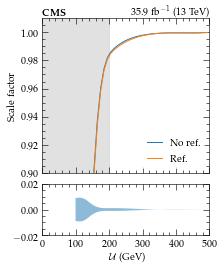

In [27]:
fig, ax = plt.subplots(
    figsize=(3, 4),
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (3, 1), "hspace": 0.1},
)
binning = np.arange(100., 500., 10.)

df_wlv_total = (
    df_mc.loc[("central", "METnoX_pt", "SingleMuon", pd.IndexSlice[:], pd.IndexSlice[:], pd.IndexSlice[:], "WJetsToMuNu"), :]
    .groupby("binvar0").sum()
)
df_wlv_pass = (
    df_mc.loc[("central", "METnoX_pt", "SingleMuon", True, pd.IndexSlice[:], pd.IndexSlice[:], "WJetsToMuNu"), :]
    .groupby("binvar0").sum()
)

df_1mu_total = (
    df_data.loc[("central", "METnoX_pt", "SingleMuon", pd.IndexSlice[:], True, pd.IndexSlice[:], "SingleMuon"), :]
    .groupby("binvar0").sum()
)
df_1mu_pass = (
    df_data.loc[("central", "METnoX_pt", "SingleMuon", True, True, pd.IndexSlice[:], "SingleMuon"), :]
    .groupby("binvar0").sum()
)

df_sf_1mu, df_sf_1mu_up, df_sf_1mu_down = calculate_scalefactor(
    binning, df_1mu_pass, df_1mu_total, df_wlv_pass, df_wlv_total,
)

    
df_wlv_ref_total = (
    df_mc.loc[("central", "METnoX_pt", "SingleMuon", pd.IndexSlice[:], True, pd.IndexSlice[:], "WJetsToMuNu"), :]
    .groupby("binvar0").sum()
)
df_wlv_ref_pass = (
    df_mc.loc[("central", "METnoX_pt", "SingleMuon", True, True, pd.IndexSlice[:], "WJetsToMuNu"), :]
    .groupby("binvar0").sum()
)

df_sf_1mu_ref, df_sf_1mu_ref_up, df_sf_1mu_ref_down = calculate_scalefactor(
    binning, df_1mu_pass, df_1mu_total, df_wlv_ref_pass, df_wlv_ref_total,
)
    
bins = list(df_sf_1mu.index.get_level_values("binvar0").unique())
bins = np.array(bins + [2*bins[-1]-bins[-2]])
bin_cents = (bins[:-1] + bins[1:])/2.

df_sf_1mu_smooth = dftools.smooth.unispline_to_gausfilter(
    bin_cents, df_sf_1mu, spline_kw={"w": 1/df_sf_1mu_up, "k": 3},
    filter_kw={"sigma": 1},
)
df_sf_1mu_ref_smooth = dftools.smooth.unispline_to_gausfilter(
    bin_cents, df_sf_1mu_ref, spline_kw={"w": 1/df_sf_1mu_ref_up, "k": 3},
    filter_kw={"sigma": 1},
)

ax[0].plot(bin_cents, df_sf_1mu_smooth, label=r'No ref.')
ax[0].plot(bin_cents, df_sf_1mu_ref_smooth, label=r'Ref.')
ax[0].legend(*ax[0].get_legend_handles_labels())

ax[0].set_xlim(0., 500.)
ax[0].set_ylim(0.9, 1.01)

ax[0].axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)
ax[0].set_ylabel(r'Scale factor')
dftools.draw.cms_label(ax[0], "")

ax[1].set_xlabel(r'$\mathcal{U}$ (GeV)')

df_sf_diff = np.abs(df_sf_1mu_smooth - df_sf_1mu_ref_smooth)/df_sf_1mu_smooth
data_systs["ReferenceSystematicUp"] = df_sf_diff
data_systs["ReferenceSystematicDown"] = df_sf_diff
ax[1].fill_between(
    bins,
    list(df_sf_diff)+[0.],
    list(-df_sf_diff)+[0.],
    alpha=0.5,
)
ax[1].set_ylim(-0.02, 0.02)
ax[0].axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)

pass

### Nominal - QCD systematic

Difference between the SF in the nominal SingleMuon and QCD sideband equivalent regions. DoubleMuon region has lower stats so we'll take the differences as a systematic from the SingleMuon region

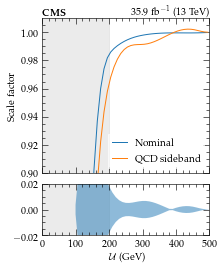

In [28]:
fig, ax = plt.subplots(
    figsize=(3, 4),
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (3, 1), "hspace": 0.1},
)
binning = np.arange(100., 500., 10.)

df_wlv_total = (
    df_mc.loc[("central", "METnoX_pt", "SingleMuon", pd.IndexSlice[:], pd.IndexSlice[:], pd.IndexSlice[:], "WJetsToMuNu"), :]
    .groupby("binvar0").sum()
)
df_wlv_pass = (
    df_mc.loc[("central", "METnoX_pt", "SingleMuon", True, pd.IndexSlice[:], pd.IndexSlice[:], "WJetsToMuNu"), :]
    .groupby("binvar0").sum()
)

df_1mu_total = (
    df_data.loc[("central", "METnoX_pt", "SingleMuon", pd.IndexSlice[:], True, pd.IndexSlice[:], "SingleMuon"), :]
    .groupby("binvar0").sum()
)
df_1mu_pass = (
    df_data.loc[("central", "METnoX_pt", "SingleMuon", True, True, pd.IndexSlice[:], "SingleMuon"), :]
    .groupby("binvar0").sum()
)

df_sf_1mu, df_sf_1mu_up, df_sf_1mu_down = calculate_scalefactor(
    binning, df_1mu_pass, df_1mu_total, df_wlv_pass, df_wlv_total,
)

    
df_wlv_qcd_total = (
    df_mc.loc[("central", "METnoX_pt", "SingleMuonQCD", pd.IndexSlice[:], pd.IndexSlice[:], pd.IndexSlice[:], "WJetsToMuNu"), :]
    .groupby("binvar0").sum()
)
df_wlv_qcd_pass = (
    df_mc.loc[("central", "METnoX_pt", "SingleMuonQCD", True, pd.IndexSlice[:], pd.IndexSlice[:], "WJetsToMuNu"), :]
    .groupby("binvar0").sum()
)

df_1mu_qcd_total = (
    df_data.loc[("central", "METnoX_pt", "SingleMuonQCD", pd.IndexSlice[:], True, pd.IndexSlice[:], "SingleMuon"), :]
    .groupby("binvar0").sum()
)
df_1mu_qcd_pass = (
    df_data.loc[("central", "METnoX_pt", "SingleMuonQCD", True, True, pd.IndexSlice[:], "SingleMuon"), :]
    .groupby("binvar0").sum()
)

df_sf_1mu_qcd, df_sf_1mu_qcd_up, df_sf_1mu_qcd_down = calculate_scalefactor(
    binning, df_1mu_qcd_pass, df_1mu_qcd_total, df_wlv_qcd_pass, df_wlv_qcd_total,
)

    
bins = list(df_sf_1mu.index.get_level_values("binvar0").unique())
bins = np.array(bins + [2*bins[-1]-bins[-2]])
bin_cents = (bins[:-1] + bins[1:])/2.

df_sf_1mu_smooth = dftools.smooth.unispline_to_gausfilter(
    bin_cents, df_sf_1mu, spline_kw={"w": 1/df_sf_1mu_up, "k": 3},
    filter_kw={"sigma": 1},
)
df_sf_1mu_qcd_smooth = dftools.smooth.unispline_to_gausfilter(
    bin_cents, df_sf_1mu_qcd, spline_kw={"w": 1/df_sf_1mu_qcd_up, "k": 3},
    filter_kw={"sigma": 1},
)

ax[0].plot(bin_cents, df_sf_1mu_smooth, label=r'Nominal')
ax[0].plot(bin_cents, df_sf_1mu_qcd_smooth, label=r'QCD sideband')
ax[0].legend(*ax[0].get_legend_handles_labels())

ax[0].set_xlim(0., 500.)
ax[0].set_ylim(0.9, 1.01)

ax[0].axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)
ax[0].set_ylabel(r'Scale factor')
dftools.draw.cms_label(ax[0], "")

ax[1].set_xlabel(r'$\mathcal{U}$ (GeV)')

df_sf_diff = np.abs(df_sf_1mu_smooth - df_sf_1mu_qcd_smooth)/df_sf_1mu_smooth
data_systs["RegionSystematicUp"] = df_sf_diff
data_systs["RegionSystematicDown"] = df_sf_diff
ax[1].fill_between(
    bins,
    list(df_sf_diff)+[0.],
    list(-df_sf_diff)+[0.],
    alpha=0.5,
)
ax[1].set_ylim(-0.02, 0.02)
ax[1].axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)

pass

In [29]:
data_systs["binvar0"] = binning
df_systs = pd.DataFrame(data_systs).set_index("binvar0")
df_systs = df_systs.reset_index()
df_systs["label"] = "METNoMu_CleanedMET_IsoTrack"
df_systs["vars"] = "METnoX_pt"
df_systs["var0_max"] = list(df_systs["binvar0"].values)[1:] + [np.infty]
df_systs["systs"] = "MuonMultiplicity_ReferenceTrigger_Region"
df_systs.columns = [
    "var0_min", "value",
    "syst0_up", "syst0_down",
    "syst1_up", "syst1_down",
    "syst2_up", "syst2_down",
    "label", "vars", "var0_max",
    "systs",
]
df_systs = df_systs[[
     "label", "vars",
    "var0_min", "var0_max",
    "value",
    "systs",
    "syst0_up", "syst0_down",
    "syst1_up", "syst1_down",
    "syst2_up", "syst2_down",
]]
x_new = np.arange(0.5, 500., 1.)
x_old = np.arange(105., 496., 10.)

df_new = pd.DataFrame({
    "label": ["METNoMu_CleanedMET_IsoTrack"]*(x_new.shape[0]),
    "vars": ["METnoX_pt"]*(x_new.shape[0]),
    "systs": ["MuonMultiplicity_ReferenceTrigger_Region"]*(x_new.shape[0]),
    "var0_min": np.arange(0., 499.5, 1.),
    "var0_max": np.arange(1., 500.5, 1.),
    "value": np.interp(x_new, x_old, df_systs["value"]),
    "syst0_up": np.interp(x_new, x_old, df_systs["syst0_up"]),
    "syst0_down": np.interp(x_new, x_old, df_systs["syst0_down"]),
    "syst1_up": np.interp(x_new, x_old, df_systs["syst1_up"]),
    "syst1_down": np.interp(x_new, x_old, df_systs["syst1_down"]),
    "syst2_up": np.interp(x_new, x_old, df_systs["syst2_up"]),
    "syst2_down": np.interp(x_new, x_old, df_systs["syst2_down"]),
})
df_new.loc[(df_new["var0_max"]==df_new["var0_max"].max(),"var0_max")] = np.inf
df_new.to_csv(
    "/home/hep/sdb15/public_html/Analysis/ZinvWidth/data/mettrigger/legacy/met_trigger_sf.csv",
    index=False,
)


### Dependence on other variables

Check the dependence of the MET trigger efficiency (scale-factor?) with other variables, such as the muon $p_{\mathrm{T}}$. Need to remake the histograms with the MET cut in place since we don't want the low MET events to contaminate these.

In [30]:
hists = ["METnoX_pt", "MET_pt", "LeadJetSelection_pt", "LeadMuonSelection_pt", "SecondMuonSelection_pt", "LeadElectronSelection_pt", "SecondElectronSelection_pt", "LeadTauSelection_pt", "PV_npvsGood"]
cfg_data_metcut = generate_yaml(
    hists,
    ["IsCertified", "Flag_goodVertices", "Flag_globalSuperTightHalo2016Filter", "Flag_HBHENoiseFilter", "Flag_HBHENoiseIsoFilter", "Flag_EcalDeadCellTriggerPrimitiveFilter", "Flag_BadPFMuonFilter", "Flag_eeBadScFilter", "MET_dCaloMET<0.6", "nJetSelection>0", "nJetSelection==nJetVeto", "LeadJetSelection_chHEF>0.1", "LeadJetSelection_neHEF<0.8", "LeadJetSelection_pt>200.", "nPhotonVeto==0", "nBJetVeto==0", "METnoX_pt>200."],
    "/vols/cms/sdb15/Analysis/ZinvWidth/databases/2019/08_Aug/28_Legacy/Data/*.h5",
    mc=False,
)

from pprint import pprint
with open("configs/data_metcut.yaml", "w") as f:
    yaml.dump(cfg_data, f, indent=4)
    
cfg_mc_metcut = generate_yaml(
    hists,
    ["(parent!='EWKV2Jets' | nGenBosonSelection==1)", "Flag_goodVertices", "Flag_globalSuperTightHalo2016Filter", "Flag_HBHENoiseFilter", "Flag_HBHENoiseIsoFilter", "Flag_EcalDeadCellTriggerPrimitiveFilter", "Flag_BadPFMuonFilter", "MET_dCaloMET<0.6", "nJetSelection>0", "nJetSelection==nJetVeto", "LeadJetSelection_chHEF>0.1", "LeadJetSelection_neHEF<0.8", "LeadJetSelection_pt>200.", "METnoX_pt>200."],
    "/vols/cms/sdb15/Analysis/ZinvWidth/databases/2019/08_Aug/28_Legacy/MC/*.h5",
    mc=True,
)
with open("configs/mc_metcut.yaml", "w") as f:
    yaml.dump(cfg_mc, f, indent=4)

In [42]:
help(dftools.draw.data_mc)

Help on function data_mc in module dftools.draw:

data_mc(ax, df_data, df_mc, label, bins, blind=False, log=True, legend=True, ratio=True, sm_total=True, mcstat_top=False, mc_kw={}, mcstat_kw={}, sm_kw={}, data_kw={}, proc_kw={}, legend_kw={}, cms_kw={})



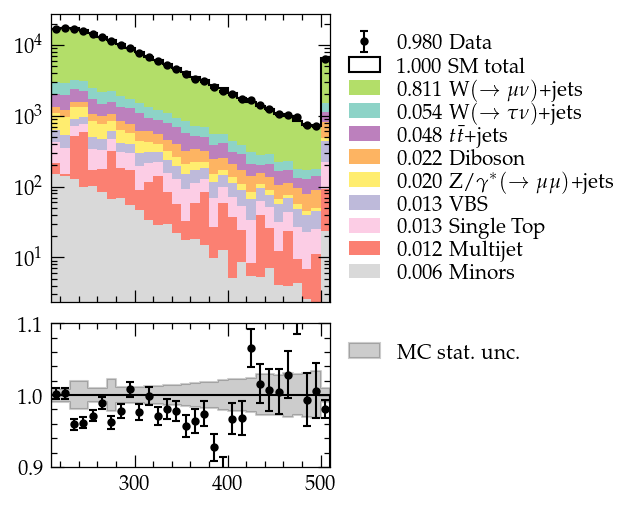

In [72]:
df_data = pd.read_hdf("met_trigger.h5", "DataAggEvents")
df_mc = pd.read_hdf("met_trigger.h5", "MCAggEvents")

binning = np.arange(0., 501., 10.)
_df_data = dftools.transform.rebin(
    df_data.loc[("central", "METnoX_pt", "SingleMuon", pd.IndexSlice[:], True, pd.IndexSlice[:], "MET"),:],
    binning,
).groupby("binvar0").sum()
    
_df_mc = dftools.transform.merge(
    dftools.transform.rebin(
        df_mc.loc[("central", "METnoX_pt", "SingleMuon", pd.IndexSlice[:], pd.IndexSlice[:], pd.IndexSlice[:]),:],
        binning,
    ).groupby(["parent", "binvar0"]).sum(), {
        "Minor": ["DYJetsToTauHTauH", "DYJetsToEE", "WJetsToENu", "ZJetsToNuNu", "VGamma", "DYJetsToTauLTauL", "DYJetsToTauHTauL", "G1Jet"],
    },
)

fig, ax = plt.subplots(
    figsize=(3, 4), dpi=150,
    nrows=2, ncols=1, sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2, 1), "hspace": 0.1, "wspace": 0.1},
)
ax[1].set_ylim(0.9, 1.1)

binning = binning[binning>200.]
_df_data = _df_data.loc[(_df_data.index.get_level_values("binvar0")>200.),:]
_df_mc = _df_mc.loc[(_df_mc.index.get_level_values("binvar0")>200.),:]

dftools.draw.data_mc(
    ax, _df_data, _df_mc, "binvar0", binning,
    proc_kw={
        "labels": {"SMTotal": r'SM total', "MET": r'MET', "SingleMuon": r'Single Muon', "SingleElectron": r'Single Electron', "ZJetsToNuNu": r'$\mathrm{Z}(\rightarrow \nu\nu)$+jets', "WJetsToLNu": r'$\mathrm{W}(\rightarrow l\nu)$+jets', "WJetsToENu": r'$\mathrm{W}(\rightarrow e\nu)$+jets', "WJetsToMuNu": r'$\mathrm{W}(\rightarrow \mu\nu)$+jets', "WJetsToTauNu": r'$\mathrm{W}(\rightarrow \tau\nu)$+jets', "WJetsToTauLNu": r'$\mathrm{W}(\rightarrow \tau_{l}\nu)$+jets', "WJetsToTauHNu": r'$\mathrm{W}(\rightarrow \tau_{h}\nu)$+jets', "Diboson": r'Diboson', "DYJetsToLL": r'$\mathrm{Z}/\gamma^{*}(\rightarrow ll)$+jets', "DYJetsToEE": r'$\mathrm{Z}/\gamma^{*}(\rightarrow ee)$+jets', "DYJetsToMuMu": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \mu\mu)$+jets', "DYJetsToTauTau": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau\tau)$+jets', "DYJetsToTauLTauL": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau_{l}\tau_{l})$+jet', "DYJetsToTauHTauL": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau_{l}\tau_{h})$+jet', "DYJetsToTauHTauH": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau_{h}\tau_{h})$+jet', "EWKV2Jets": r'VBS', "SingleTop": r'Single Top', "TTJets": r'$t\bar{t}$+jets', "QCD": r'Multijet', "G1Jet": r'$\gamma$+jets', "VGamma": r'$V+\gamma$', "Minor": r'Minors'},
        "colours": {"SMTotal": 'black', "MET": "black", "SingleMuon": "black", "SingleElectron": "black", "ZJetsToNuNu": '#80b1d3', "WJetsToLNu": '#b3de69', "WJetsToENu": '#b2df8a', "WJetsToMuNu": '#b3de69', "WJetsToTauNu": '#8dd3c7', "WJetsToTauLNu": '#8dd3c7', "WJetsToTauHNu": '#8dd3c7', "Diboson": '#fdb462', "DYJetsToLL": '#ffed6f', "DYJetsToEE": '#fff6b3', "DYJetsToMuMu": '#ffed6f', "DYJetsToTauTau": '#ffe41a', "DYJetsToTauLTauL": '#ffe41a', "DYJetsToTauHTauL": '#ffe41a', "DYJetsToTauHTauH": '#ffe41a', "EWKV2Jets": '#bebada', "SingleTop": '#fccde5', "TTJets": '#bc80bd', "QCD": '#fb8072', "G1Jet": '#ccebc5', "VGamma": '#ffffb3', "Minor": '#d9d9d9'},
    },
)
pass

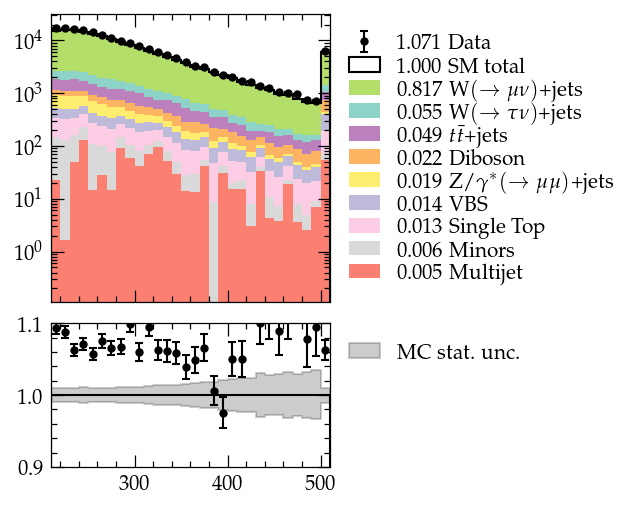

In [73]:
df_data = pd.read_hdf("met_trigger.h5", "DataAggEvents")
df_mc = pd.read_hdf("met_trigger.h5", "MCAggEvents")

binning = np.arange(0., 501., 10.)
_df_data = dftools.transform.rebin(
    df_data.loc[("central", "METnoX_pt", "SingleMuon", pd.IndexSlice[:], True, pd.IndexSlice[:], "SingleMuon"),:],
    binning,
).groupby("binvar0").sum()
    
_df_mc = dftools.transform.merge(
    dftools.transform.rebin(
        df_mc.loc[("central", "METnoX_pt", "SingleMuon", pd.IndexSlice[:], True, pd.IndexSlice[:]),:],
        binning,
    ).groupby(["parent", "binvar0"]).sum(), {
        "Minor": ["DYJetsToTauHTauH", "DYJetsToEE", "WJetsToENu", "ZJetsToNuNu", "VGamma", "DYJetsToTauLTauL", "DYJetsToTauHTauL", "G1Jet"],
    },
)

fig, ax = plt.subplots(
    figsize=(3, 4), dpi=150,
    nrows=2, ncols=1, sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2, 1), "hspace": 0.1, "wspace": 0.1},
)
ax[1].set_ylim(0.9, 1.1)

binning = binning[binning>200.]
_df_data = _df_data.loc[(_df_data.index.get_level_values("binvar0")>200.),:]
_df_mc = _df_mc.loc[(_df_mc.index.get_level_values("binvar0")>200.),:]

dftools.draw.data_mc(
    ax, _df_data, _df_mc, "binvar0", binning,
    proc_kw={
        "labels": {"SMTotal": r'SM total', "MET": r'MET', "SingleMuon": r'Single Muon', "SingleElectron": r'Single Electron', "ZJetsToNuNu": r'$\mathrm{Z}(\rightarrow \nu\nu)$+jets', "WJetsToLNu": r'$\mathrm{W}(\rightarrow l\nu)$+jets', "WJetsToENu": r'$\mathrm{W}(\rightarrow e\nu)$+jets', "WJetsToMuNu": r'$\mathrm{W}(\rightarrow \mu\nu)$+jets', "WJetsToTauNu": r'$\mathrm{W}(\rightarrow \tau\nu)$+jets', "WJetsToTauLNu": r'$\mathrm{W}(\rightarrow \tau_{l}\nu)$+jets', "WJetsToTauHNu": r'$\mathrm{W}(\rightarrow \tau_{h}\nu)$+jets', "Diboson": r'Diboson', "DYJetsToLL": r'$\mathrm{Z}/\gamma^{*}(\rightarrow ll)$+jets', "DYJetsToEE": r'$\mathrm{Z}/\gamma^{*}(\rightarrow ee)$+jets', "DYJetsToMuMu": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \mu\mu)$+jets', "DYJetsToTauTau": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau\tau)$+jets', "DYJetsToTauLTauL": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau_{l}\tau_{l})$+jet', "DYJetsToTauHTauL": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau_{l}\tau_{h})$+jet', "DYJetsToTauHTauH": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau_{h}\tau_{h})$+jet', "EWKV2Jets": r'VBS', "SingleTop": r'Single Top', "TTJets": r'$t\bar{t}$+jets', "QCD": r'Multijet', "G1Jet": r'$\gamma$+jets', "VGamma": r'$V+\gamma$', "Minor": r'Minors'},
        "colours": {"SMTotal": 'black', "MET": "black", "SingleMuon": "black", "SingleElectron": "black", "ZJetsToNuNu": '#80b1d3', "WJetsToLNu": '#b3de69', "WJetsToENu": '#b2df8a', "WJetsToMuNu": '#b3de69', "WJetsToTauNu": '#8dd3c7', "WJetsToTauLNu": '#8dd3c7', "WJetsToTauHNu": '#8dd3c7', "Diboson": '#fdb462', "DYJetsToLL": '#ffed6f', "DYJetsToEE": '#fff6b3', "DYJetsToMuMu": '#ffed6f', "DYJetsToTauTau": '#ffe41a', "DYJetsToTauLTauL": '#ffe41a', "DYJetsToTauHTauL": '#ffe41a', "DYJetsToTauHTauH": '#ffe41a', "EWKV2Jets": '#bebada', "SingleTop": '#fccde5', "TTJets": '#bc80bd', "QCD": '#fb8072', "G1Jet": '#ccebc5', "VGamma": '#ffffb3', "Minor": '#d9d9d9'},
    },
)
pass

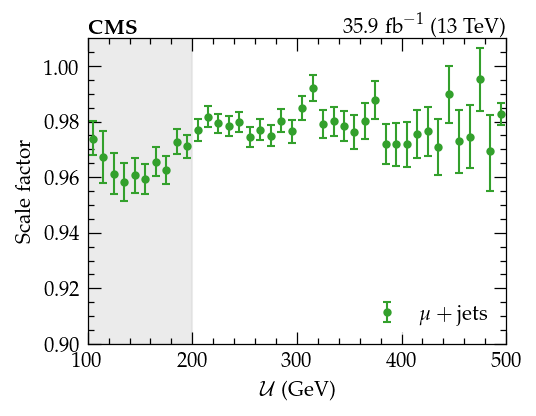

In [74]:
fig, ax = plt.subplots(
    figsize=(3.6, 2.7), dpi=150,
)
binning = np.arange(100., 500., 10.)

draw_scalefactors(
    ax, df_data, df_mc, [
        ("SingleMuon", "MET", "SingleMuon", "WJetsToMuNu", r'$\mu+\mathrm{jets}$', '#33a02c'),
    ], binning, hist="METnoX_pt",
    data_tag=[True, pd.IndexSlice[:], pd.IndexSlice[:]],
    data_probe=[True, True, pd.IndexSlice[:]],
    mc_tag=[pd.IndexSlice[:], pd.IndexSlice[:], pd.IndexSlice[:]],
    mc_probe=[pd.IndexSlice[:], True, pd.IndexSlice[:]],
)

ax.axvspan(0, 200, color="#d9d9d9", alpha=0.5, zorder=-1)
ax.set_ylim(0.9, 1.01)

ax.set_xlabel(r'$\mathcal{U}$ (GeV)')
ax.set_ylabel(r'Scale factor')

ax.legend(*ax.get_legend_handles_labels(), loc=4)
fig.savefig("plots/met_trig_sf.pdf", format='pdf', bbox_inches='tight')
pass